activate the environment

In [1]:
using Pkg

Pkg.activate(".")

  Activating project at `~/julia-epidemiology-models`


In [ ]:
# Pkg.update()
# Pkg.resolve()
# Pkg.precompile()
# Pkg.instantiate()

import and include to set everything ready

In [3]:
using Agents, DataFrames, Plots, Distributions, Random, Dates, Distributed
using Statistics: mean

@everywhere include("./src/utils.jl")
@everywhere include("./src/graph.jl")
@everywhere include("./src/controller.jl")
@everywhere include("./src/ode.jl")

some utility functions

In [5]:
gr()

function save_plot(plot, path="", title="title", format="png")
    isdir(path) == false && mkpath(path)
    savefig(plot, path * title * "_" * string(today()) * "." * format)
end

function split_dataset(data)
    p1 = select(
        data,
        [:susceptible_status, :exposed_status, :infected_status, :recovered_status, :dead],
    )
    p2 = select(data, [:active_countermeasures, :happiness])
    p3 = select(data, [:R₀])
    return p1, p2, p3
end

function test_dataset(url::String, path::String, iso_code::String)
    dataset.download_dataset(path, url)
    df = dataset.read_dataset("data/OWID/owid-covid-data.csv")
    return dataset.dataset_from_location(df, iso_code)
end

test_dataset (generic function with 1 method)

obtain the dataset and start to manipulate it in a way it seems fit. (https://covid.ourworldindata.org/data/owid-covid-data.csv)

In [7]:
date, day_info, total_count, R₀ = test_dataset(
    "https://covid.ourworldindata.org/data/owid-covid-data.csv",
    "data/OWID/",
    "ITA",
)

(1266×1 DataFrame
  Row │ date       
      │ Date       
──────┼────────────
    1 │ 2020-01-03
    2 │ 2020-01-04
    3 │ 2020-01-05
    4 │ 2020-01-06
    5 │ 2020-01-07
    6 │ 2020-01-08
    7 │ 2020-01-09
    8 │ 2020-01-10
  ⋮   │     ⋮
 1260 │ 2023-06-15
 1261 │ 2023-06-16
 1262 │ 2023-06-17
 1263 │ 2023-06-18
 1264 │ 2023-06-19
 1265 │ 2023-06-20
 1266 │ 2023-06-21
  1251 rows omitted, 1266×4 DataFrame
  Row │ new_cases_smoothed  new_tests_smoothed  new_vaccinations_smoothed  new ⋯
      │ Float64?            Float64?            Float64?                   Flo ⋯
──────┼─────────────────────────────────────────────────────────────────────────
    1 │         missing                missing                  missing        ⋯
    2 │         missing                missing                  missing       
    3 │         missing                missing                  missing       
    4 │         missing                missing                  missing       
    5 │         missing 

plot the current situation obtained from the data above

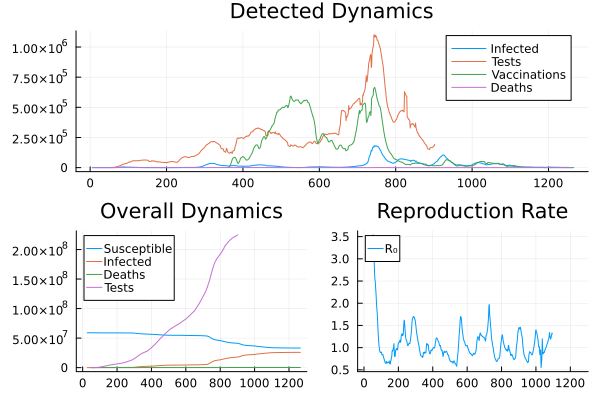

In [8]:
l = @layout [
    grid(1, 1)
    grid(1, 2)
]
p = plot(
    plot(
        Array(day_info),
        labels=["Infected" "Tests" "Vaccinations" "Deaths"],
        title="Detected Dynamics",
    ),
    plot(
        Array(total_count),
        labels=["Susceptible" "Infected" "Deaths" "Tests"],
        title="Overall Dynamics",
    ),
    plot(Array(R₀), labels="R₀", title="Reproduction Rate"),
    layout=l,
)

try some system identification, meaning from a dataset extrapolate with a data driven approach the system and dynamics that generate such data. This method is, for some reason unstable.

In [9]:
i = 1
while true
    try
        p = parameters.get_abm_parameters(20, 0.01, 3300)
        model = graph.init(; p...)
        data = graph.collect(model; n=30, showprogress=true)

        d = select(
            data,
            [:susceptible_status, :exposed_status, :infected_status, :recovered_status, :dead],
        )

        eq, (prob, sol) = SysId.system_identification(d; saveplot=true)
        p = plot(plot(prob), plot(sol))

        println("successful iterazion: $i")
        break
    catch
        # println("failed iteration: $i")
        i += 1
    end
end

after that is good to show some result from the use of an ODE system

In [ ]:
u, p, t = parameters.get_ode_parameters(20, 3300)
prob = ode.get_ode_problem(ode.seir!, u, t, p)
sol = ode.get_ode_solution(prob)

p = plot(
    sol,
    labels=["Susceptible" "Exposed" "Infected" "Recovered" "Dead"],
    title="SEIR Dynamics NO INTERVENTION",
)

in comparison to a full deterministic model is good to show a stochastic one, an agent-based model

In [ ]:
abm_parameters = parameters.get_abm_parameters(20, 0.01, 3300)
model = graph.init(; abm_parameters...)

data = graph.collect(model; n=1200, showprogress=true)
graph.save_dataframe(data, "data/abm/", "ABM SEIR NO INTERVENTION")
# df = graph.load_dataset("data/abm/ABM SEIR NO INTERVENTION_" * string(today()) * ".csv")

p1, p2, p3 = split_dataset(data)
l = @layout [
    grid(1, 1)
    grid(1, 2)
]
p = plot(
    plot(
        Array(p1),
        labels=["Susceptible" "Exposed" "Infected" "Recovered" "Dead"],
        title="ABM Dynamics",
    ),
    plot(Array(p2), labels=["η" "Happiness"], title="Agents response to η"),
    plot(Array(p3), labels="R₀", title="Reproduction number"),
    layout=l,
)

is possible to run N different simulation using either the ODE system approach, in particular the Stochastic one, or the ABM. 

Both the approach lies on the ensemblerun! method that allow the user to specify N different models and run it sequentially or in parallel. 

For the sake of this notebook I used this approach for just the abm. Even though is completely fine and allow to use this approach to solve SDE System (in fact is even suggested due to the nature of the system involved)

In [ ]:
abm_parameters = parameters.get_abm_parameters(20, 0.01, 3300)
models = [graph.init(; seed=i, abm_parameters...) for i in rand(UInt64, 100)]
data = graph.ensemble_collect(models; n=1200, showprogress=true, parallel=true)
graph.save_dataframe(data, "data/abm/", "ENSEMBLE ABM SEIR NO INTERVENTION")
ens_data = dataset.read_dataset("data/abm/ENSEMBLE ABM SEIR NO INTERVENTION_" * string(today()) * ".csv")
d = [filter(:ensemble => ==(i), ens_data) for i in unique(ens_data[!, :ensemble])]
res_seir = DataFrame(
    [
        [], [], [], [], [], [], [], [], [], [], [], [], [], [], []
    ],
    [
        "lb_s", "avg_s", "ub_s",
        "lb_e", "avg_e", "ub_e",
        "lb_i", "avg_i", "ub_i",
        "lb_r", "avg_r", "ub_r",
        "lb_d", "avg_d", "ub_d"
    ]
)
res_hη = DataFrame(
    [
        [], [], [], [], [], []
    ],
    [
        "lb_h", "avg_h", "ub_h", "lb_η", "avg_η", "ub_η"
    ]
)
res_r0 = DataFrame(
    [
        [], [], []
    ],
    [
        "lb_R0", "avg_R0", "ub_R0"
    ]
)
for i = 1:length(d[1][:, 1])
    s = [d[j][i, :susceptible_status] for j = 1:length(d)]
    e = [d[j][i, :exposed_status] for j = 1:length(d)]
    is = [d[j][i, :infected_status] for j = 1:length(d)]
    r = [d[j][i, :recovered_status] for j = 1:length(d)]
    dd = [d[j][i, :dead] for j = 1:length(d)]

    ms = mean(s)
    me = mean(e)
    mi = mean(is)
    mr = mean(r)
    md = mean(dd)
    push!(
        res_seir,
        [
            ms - minimum(s), ms, maximum(s) - ms,
            me - minimum(e), me, maximum(e) - me,
            mi - minimum(is), mi, maximum(is) - mi,
            mr - minimum(r), mr, maximum(r) - mr,
            md - minimum(dd), md, maximum(dd) - md
        ]
    )

    h = [d[j][i, :happiness] for j = 1:length(d)]
    η = [d[j][i, :active_countermeasures] for j = 1:length(d)]
    mh = mean(h)
    mη = mean(η)
    push!(
        res_hη,
        [
            mh - minimum(h), mean(h), maximum(h) - mh,
            mη - minimum(η), mean(η), maximum(η) - mη
        ]
    )

    r0 = [d[j][i, :R₀] for j = 1:length(d)]
    mr0 = mean(r0)
    push!(
        res_r0,
        [
            mr0 - minimum(r0), mean(r0), maximum(r0) - mr0
        ]
    )
end

p1 = plot(res_seir[!, :avg_s], ribbon=(res_seir[!, :lb_s], res_seir[!, :ub_s]), labels="Susceptible",
    title="ABM Dynamics")
plot!(res_seir[!, :avg_e], ribbon=(res_seir[!, :lb_e], res_seir[!, :ub_e]), labels="Exposed")
plot!(res_seir[!, :avg_i], ribbon=(res_seir[!, :lb_i], res_seir[!, :ub_i]), labels="Infected")
plot!(res_seir[!, :avg_r], ribbon=(res_seir[!, :lb_r], res_seir[!, :ub_r]), labels="Recovered")
plot!(res_seir[!, :avg_d], ribbon=(res_seir[!, :lb_d], res_seir[!, :ub_d]), labels="Dead")

p2 = plot(res_hη[!, :avg_h], ribbon=(res_hη[!, :lb_h], res_hη[!, :ub_h]), labels="happiness", title="Agents response to η")
plot!(res_hη[!, :avg_η], ribbon=(res_hη[!, :lb_η], res_hη[!, :ub_η]), labels="η")

p3 = plot(res_r0[!, :avg_R0], ribbon=(res_r0[!, :lb_R0], res_r0[!, :ub_R0]), labels="R₀", title="Reproduction number")

l = @layout [
    grid(1, 1)
    grid(1, 2)
]
p = plot(p1, p2, p3, layout=l)

last but not least I want to show the use of Neural Networks and Universal ODE to predict the behaviour of a curve. Note that the curve from the system in hand is completely chaotic and pretty difficult to predict having a small amount of data. 

In [ ]:
i = 1
while true
    try
        abm_parameters = parameters.get_abm_parameters(20, 0.01, 3300)
        model = graph.init(; abm_parameters...)
        n = 50
        sp = n * 3 # short term prediction
        data = graph.collect(model; n=sp, showprogress=true)
        ddata = select(
            data,
            [:susceptible_status, :exposed_status, :infected_status, :recovered_status, :dead],
        )
        Xₙ = Array(ddata)
        p_true = [3.54, 1 / 14, 1 / 5, 1 / 280, 0.007, 0.0, 0.0]
        # Eye control
        pred = udePredict.ude_prediction(
            ddata[1:n, :],
            p_true,
            round(Int, n * 1.5);
            lossTitle="LOSS",
            plotLoss=true,
            maxiters=2000
        )
        p = scatter(
            Array(Xₙ ./ sum(Xₙ[1, :])),
            label=["True S" "True E" "True I" "True R" "True D"],
        )
        plot!(
            transpose(pred[1]),
            xlabel="t",
            label=["Estimated S" "Estimated E" "Estimated I" "Estimated R" "Estimated D"],
            title="NN Approximation",
        )
        plot!(p, [n - 0.01, n + 0.01], [0.0, 1.0], lw=2, color=:black, label=nothing)
        annotate!([(n / 3, 1.0, text("Training Data", :center, :top, :black))])
        # test symbolic regression
        long_time_estimation =
            udePredict.symbolic_regression(pred[1], pred[2], p_true, sp; maxiters=10_000)

        p1 = scatter(
            Array(Xₙ ./ sum(Xₙ[1, :])),
            label=["True S" "True E" "True I" "True R" "True D"],
        )
        plot!(
            long_time_estimation,
            xlabel="t",
            label=["Estimated S" "Estimated E" "Estimated I" "Estimated R" "Estimated D"],
            title="NN + SINDy Approximation",
        )
        plot!(p1, [n - 0.01, n + 0.01], [0.0, 1.0], lw=2, color=:black, label=nothing)
        annotate!([(n / 3, 1.0, text("Training Data", :center, :top, :black))])

        pt = plot(plot(p), plot(p1))
        save_plot(pt, "img/prediction/", "PREDICTION", "pdf")
        println("successful iterazion: $i")
        break
    catch
        #println("failed iteration: $i")
        i += 1
    end
end